In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [9]:
data_transaction = pd.read_csv("data_transaction.csv")
data_identity = pd.read_csv("data_identity.csv")

In [10]:
data = data_transaction.set_index('TransactionID').join(data_identity.set_index('TransactionID'))

In [11]:
data = data.sample(100000)

In [12]:
labels = data['isFraud']

In [13]:
all_features = np.array(data.columns[1:])

In [14]:
transaction_cat_features = ["ProductCD"] + \
                           [f"card{i}" for i in range(1, 7)] + \
                           ["addr1", "addr2"] + \
                           ["P_emaildomain", "R_emaildomain"] + \
                           [f"M{i}" for i in range(1, 10)]
len(transaction_cat_features)

20

In [15]:
identity_cat_features = ["DeviceType", "DeviceInfo"] + [f"id_{i}" for i in range(12, 39)]
len(identity_cat_features)

29

In [16]:
cat_features = np.array(transaction_cat_features + identity_cat_features)
len(cat_features)

49

## Remove features where a lot of nulls

In [17]:
nan_ratio = data.isna().sum(0) / data.shape[0]

(array([111.,   0.,  48.,  22.,   0.,  20.,   0.,   0.,   1.,  17.,   1.,
          3.,   2.,   0.,   0., 133.,   1.,  60.,   5.,   9.]),
 array([0.       , 0.0496055, 0.099211 , 0.1488165, 0.198422 , 0.2480275,
        0.297633 , 0.3472385, 0.396844 , 0.4464495, 0.496055 , 0.5456605,
        0.595266 , 0.6448715, 0.694477 , 0.7440825, 0.793688 , 0.8432935,
        0.892899 , 0.9425045, 0.99211  ]),
 <BarContainer object of 20 artists>)

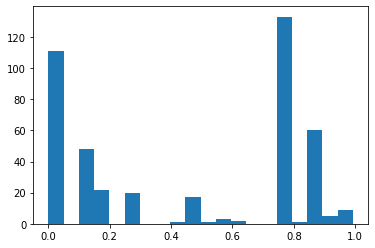

In [18]:
plt.hist(nan_ratio, bins=20)

In [19]:
enough_features = all_features[nan_ratio[1:] < 0.7]

In [20]:
len(cat_features)

49

In [21]:
enough_cat_features = cat_features[np.isin(cat_features, enough_features)]
len(enough_cat_features)

19

## Remove features with high cardinality

In [22]:
cardinalities = []

for cat_feature in enough_cat_features:
#     print(cat_feature)
    cardinalities.append(len(data[cat_feature].value_counts()) / data.shape[0])
cardinalities = np.array(cardinalities)

(array([18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.000e-05, 7.700e-03, 1.538e-02, 2.306e-02, 3.074e-02, 3.842e-02,
        4.610e-02, 5.378e-02, 6.146e-02, 6.914e-02, 7.682e-02]),
 <BarContainer object of 10 artists>)

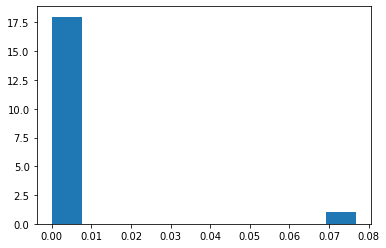

In [23]:
plt.hist(cardinalities)

(array([8., 0., 0., 1., 0., 0., 2., 0., 0., 1.]),
 array([2.0e-05, 2.3e-05, 2.6e-05, 2.9e-05, 3.2e-05, 3.5e-05, 3.8e-05,
        4.1e-05, 4.4e-05, 4.7e-05, 5.0e-05]),
 <BarContainer object of 10 artists>)

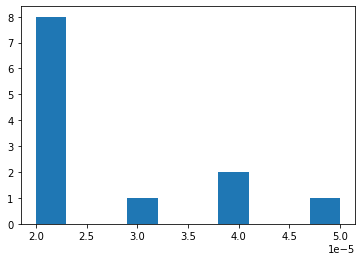

In [24]:
plt.hist(cardinalities[cardinalities < 0.0001])

In [25]:
enough_cat_and_card_features = enough_cat_features[cardinalities < 1e-5 * 3]
len(enough_cat_and_card_features)

9

In [26]:
enough_and_card_features = enough_features[~np.isin(enough_features, enough_cat_features[cardinalities >= 1e-5 * 3])]

In [27]:
data = data[enough_and_card_features]

In [28]:
def get_indicator(data):
    return (~data.isna()).astype("float")

## one hot enc

In [29]:
onehoted_data = pd.get_dummies(data, columns=enough_cat_and_card_features)

In [30]:
onehoted_data

TransactionDT  TransactionAmt  dist1   C1   C2   C3   C4   C5  \
TransactionID                                                                  
3118333              2597138          63.970    NaN  2.0  2.0  0.0  0.0  1.0   
3038142              1203703          31.500    NaN  3.0  5.0  0.0  0.0  0.0   
3130301              2940548          88.000    NaN  1.0  1.0  0.0  0.0  0.0   
3540862             14651053          35.535    NaN  2.0  3.0  0.0  2.0  0.0   
3001800               415282          39.000    3.0  1.0  2.0  0.0  0.0  0.0   
...                      ...             ...    ...  ...  ...  ...  ...  ...   
3158604              3707247          49.000  389.0  2.0  2.0  0.0  0.0  0.0   
3415015             10806517         159.950    NaN  1.0  1.0  0.0  0.0  1.0   
3165850              3896606          49.500  177.0  2.0  2.0  0.0  0.0  0.0   
3169600              4043895         209.950    NaN  2.0  1.0  0.0  0.0  1.0   
3544450             14752612          67.950    NaN  2.0  2.0  0.0  0.0  1.0   

                C6   C7  ...  M5_F  M5_T  M6_F  M6_T  M7_F  M7_T  M8_F  M8_T  \
TransactionID            ...                                                   
3118333        2.0  0.0  ...     0     0     0     0     0     0     0     0   
3038142        2.0  0.0  ...     1     0     0     1     0     0     0     0   
3130301        1.0  0.0  ...     1     0     1     0     0     0     0     0   
3540862        2.0  2.0  ...     0     0     0     0     0     0     0     0   
3001800        1.0  0.0  ...     0     1     0     1     0     0     0     0   
...            ...  ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
3158604        1.0  0.0  ...     0     1     0     1     1     0     1     0   
3415015        1.0  0.0  ...     0     0     1     0     1     0     1     0   
3165850        1.0  0.0  ...     1     0     0     0     1     0     1     0   
3169600        1.0  0.0  ...     0     0     1     0     0     0     0     0   
3544450        2.0  0.0  ...     0     0     1     0     1     0     1     0   

               M9_F  M9_T  
TransactionID              
3118333           0     0  
3038142           0     0  
3130301           0     0  
3540862           0     0  
3001800           0     0  
...             ...   ...  
3158604           1     0  
3415015           0     1  
3165850           0     1  
3169600           0     0  
3544450           0     1  

[100000 rows x 224 columns]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(onehoted_data, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=42)

## create indicator

In [32]:
indicator_train = get_indicator(X_train)
indicator_test = get_indicator(X_test)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [33]:
indicator_train

TransactionDT  TransactionAmt  dist1   C1   C2   C3   C4   C5  \
TransactionID                                                                  
3556030                  1.0             1.0    1.0  1.0  1.0  1.0  1.0  1.0   
3002719                  1.0             1.0    0.0  1.0  1.0  1.0  1.0  1.0   
3227190                  1.0             1.0    1.0  1.0  1.0  1.0  1.0  1.0   
3528271                  1.0             1.0    1.0  1.0  1.0  1.0  1.0  1.0   
3426688                  1.0             1.0    1.0  1.0  1.0  1.0  1.0  1.0   
...                      ...             ...    ...  ...  ...  ...  ...  ...   
3339241                  1.0             1.0    0.0  1.0  1.0  1.0  1.0  1.0   
3319959                  1.0             1.0    1.0  1.0  1.0  1.0  1.0  1.0   
3520945                  1.0             1.0    0.0  1.0  1.0  1.0  1.0  1.0   
3238697                  1.0             1.0    0.0  1.0  1.0  1.0  1.0  1.0   
3383562                  1.0             1.0    1.0  1.0  1.0  1.0  1.0  1.0   

                C6   C7  ...  M5_F  M5_T  M6_F  M6_T  M7_F  M7_T  M8_F  M8_T  \
TransactionID            ...                                                   
3556030        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3002719        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3227190        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3528271        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3426688        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
...            ...  ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
3339241        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3319959        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3520945        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3238697        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3383562        1.0  1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

               M9_F  M9_T  
TransactionID              
3556030         1.0   1.0  
3002719         1.0   1.0  
3227190         1.0   1.0  
3528271         1.0   1.0  
3426688         1.0   1.0  
...             ...   ...  
3339241         1.0   1.0  
3319959         1.0   1.0  
3520945         1.0   1.0  
3238697         1.0   1.0  
3383562         1.0   1.0  

[80000 rows x 224 columns]

### Undercomplete

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## Undercomplete
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(autoencoder, self).__init__()
        # Step 1 : Define the encoder 
        # Step 2 : Define the decoder
        # Step 3 : Initialize the weights (optional)

        self.encoder = nn.Sequential(
          nn.Linear(input_size, inputч_size//2),
          nn.ReLU(True),
          nn.Linear(input_size//2, input_size//3),
          nn.Linear(input_size//3, input_size//4),
          nn.Tanh(),
          nn.Linear(input_size//4, latent_dim)
      )
    
        self.decoder = nn.Sequential(
          nn.Linear(latent_dim, input_size//4),
          nn.ReLU(True),
          nn.Linear(input_size//4, input_size//3),
          nn.Linear(input_size//3, input_size//2),
          nn.Tanh(),
          nn.Linear(input_size//2, input_size)
      )
        
        self.encoder.apply(self.__init_weights)
        self.decoder.apply(self.__init_weights)
        
    def forward(self, x, indicator):
        # Step 1: Pass the input through encoder to get latent representation
        # Step 2: Take latent representation and pass through decoder
#         print(x.dtype)
#         print(indicator.dtype)
#         print(x.shape)
#         print(indicator.shape)
        x = self.encoder(x * indicator)
        x = self.decoder(x)
        return x
        

    def encode(self,input):
        #Step 1: Pass the input through the encoder to get latent representation
        return self.encoder(input)
    
    def __init_weights(self,m):
        #Init the weights (optional)
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [35]:
onehoted_data

TransactionDT  TransactionAmt  dist1   C1   C2   C3   C4   C5  \
TransactionID                                                                  
3118333              2597138          63.970    NaN  2.0  2.0  0.0  0.0  1.0   
3038142              1203703          31.500    NaN  3.0  5.0  0.0  0.0  0.0   
3130301              2940548          88.000    NaN  1.0  1.0  0.0  0.0  0.0   
3540862             14651053          35.535    NaN  2.0  3.0  0.0  2.0  0.0   
3001800               415282          39.000    3.0  1.0  2.0  0.0  0.0  0.0   
...                      ...             ...    ...  ...  ...  ...  ...  ...   
3158604              3707247          49.000  389.0  2.0  2.0  0.0  0.0  0.0   
3415015             10806517         159.950    NaN  1.0  1.0  0.0  0.0  1.0   
3165850              3896606          49.500  177.0  2.0  2.0  0.0  0.0  0.0   
3169600              4043895         209.950    NaN  2.0  1.0  0.0  0.0  1.0   
3544450             14752612          67.950    NaN  2.0  2.0  0.0  0.0  1.0   

                C6   C7  ...  M5_F  M5_T  M6_F  M6_T  M7_F  M7_T  M8_F  M8_T  \
TransactionID            ...                                                   
3118333        2.0  0.0  ...     0     0     0     0     0     0     0     0   
3038142        2.0  0.0  ...     1     0     0     1     0     0     0     0   
3130301        1.0  0.0  ...     1     0     1     0     0     0     0     0   
3540862        2.0  2.0  ...     0     0     0     0     0     0     0     0   
3001800        1.0  0.0  ...     0     1     0     1     0     0     0     0   
...            ...  ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
3158604        1.0  0.0  ...     0     1     0     1     1     0     1     0   
3415015        1.0  0.0  ...     0     0     1     0     1     0     1     0   
3165850        1.0  0.0  ...     1     0     0     0     1     0     1     0   
3169600        1.0  0.0  ...     0     0     1     0     0     0     0     0   
3544450        2.0  0.0  ...     0     0     1     0     1     0     1     0   

               M9_F  M9_T  
TransactionID              
3118333           0     0  
3038142           0     0  
3130301           0     0  
3540862           0     0  
3001800           0     0  
...             ...   ...  
3158604           1     0  
3415015           0     1  
3165850           0     1  
3169600           0     0  
3544450           0     1  

[100000 rows x 224 columns]

In [36]:
batchSize = 10000
learning_rate = 0.01
num_epochs = 30
AE = autoencoder(X_train.shape[1], 40).to(device)
print(AE)
# print(summary(AE,input_size=(1, 64)))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(AE.parameters(),lr=learning_rate)

X_train_normalized = X_train.to_numpy() / X_train.to_numpy().max(0)
X_test_normalized = X_test.to_numpy() / X_test.to_numpy().max(0)

#Create a random dataset
dataset = TensorDataset(torch.from_numpy(X_train_normalized.astype(np.float32)), 
                                       torch.from_numpy(indicator_train.to_numpy().astype(np.float32)))

data_loader = DataLoader(dataset, batch_size=batchSize,shuffle=True)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=224, out_features=112, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=112, out_features=74, bias=True)
    (3): Linear(in_features=74, out_features=56, bias=True)
    (4): Tanh()
    (5): Linear(in_features=56, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=56, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=56, out_features=74, bias=True)
    (3): Linear(in_features=74, out_features=112, bias=True)
    (4): Tanh()
    (5): Linear(in_features=112, out_features=224, bias=True)
  )
)


<ipython-input-36-88733130efbd>:12: RuntimeWarning: invalid value encountered in true_divide
  X_test_normalized = X_test.to_numpy() / X_test.to_numpy().max(0)


In [37]:
losses = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    batch_losses = []
    for X, indicator in data_loader:
        X = X.to(device)
        indicator = indicator.to(device)

        optimizer.zero_grad()
        # forward
        output = AE(X, indicator)
        loss = criterion(output * indicator , X * indicator)

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        batch_losses.append(loss.item())
        
    losses.append(np.mean(batch_losses))

100%|██████████| 30/30 [00:45<00:00,  1.51s/it]


In [39]:
torch.save(AE.state_dict(), "ae.pth")

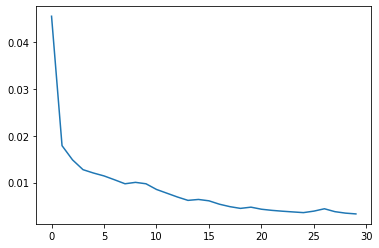

In [38]:
plt.plot(losses)

### Denoising

In [405]:
normal = torch.distributions.Normal(0, 0.5)

def add_noise(x, device=device): 
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

In [407]:
batchSize = 10000
learning_rate = 0.01
num_epochs = 30
input_size=X_train.shape[1]
latent_size = 40
DAE = autoencoder(input_size, latent_size).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(DAE.parameters(),lr = learning_rate)

X_train_normalized = X_train.to_numpy() / X_train.to_numpy().max(0)
X_test_normalized = X_test.to_numpy() / X_test.to_numpy().max(0)


#Create a random dataset
dataset = TensorDataset(torch.from_numpy(X_train_normalized.astype(np.float32)), 
                                       torch.from_numpy(indicator_train.to_numpy().astype(np.float32)))

data_loader = DataLoader(dataset, batch_size=batchSize,shuffle=True)

In [408]:
losses = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    batch_losses = []
    for X, indicator in tqdm(data_loader):
        X = X.to(device)
        indicator = indicator.to(device)
        X = add_noise(X, device)
        
        optimizer.zero_grad()
        # forward
        output = DAE(X, indicator)
        loss = criterion(output * indicator , X * indicator)

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        batch_losses.append(loss.item())
        
    losses.append(np.mean(batch_losses))

100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


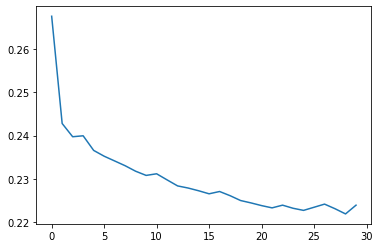

In [409]:
plt.plot(losses)

In [410]:
torch.save(DAE.state_dict(), "dae.pth")

### Variational autoencoder

In [418]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_size=input_size, h_dim=400, z_dim=40):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, input_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x, indicator):
        mu, log_var = self.encode(x * indicator)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [419]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Hyper-parameters

batchSize = 10000
learning_rate = 0.01
num_epochs = 50
input_size=X_train.shape[1]
z_dim=40


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(AE.parameters(),lr = learning_rate)

X_train_normalized = X_train.to_numpy() / X_train.to_numpy().max(0)
X_test_normalized = X_test.to_numpy() / X_test.to_numpy().max(0)


#Create a random dataset
dataset = TensorDataset(torch.from_numpy(X_train_normalized.astype(np.float32)), 
                                       torch.from_numpy(indicator_train.to_numpy().astype(np.float32)))

data_loader = DataLoader(dataset, batch_size=batchSize,shuffle=True)

In [422]:
# Start training
losses_vae=[]
for epoch in tqdm(range(num_epochs)):
    batch_losses = []
    for X, indicator in data_loader:
        # Forward pass
        X = X.to(device)
        indicator = indicator.to(device)
        output, mu, log_var = vae(X, indicator)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(output * indicator, X * indicator, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        
        batch_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses_vae.append(np.mean(batch_losses))

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


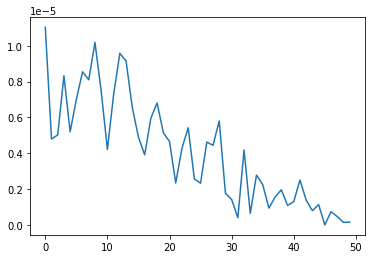

In [442]:
plt.plot(scaled_loss * np.arange(0.1, 0, -0.1 / len(losses_vae)))

In [443]:
torch.save(vae.state_dict(), "vae.pth")

# Eval

In [94]:
X_test_normalized[np.isnan(X_test_normalized)] = 0
X_train_normalized[np.isnan(X_train_normalized)] = 0

In [95]:
#Create a random dataset
dataset = TensorDataset(torch.from_numpy(X_train_normalized.astype(np.float32)), 
                                       torch.from_numpy(indicator_train.to_numpy().astype(np.float32)))

data_loader = DataLoader(dataset, batch_size = batchSize, shuffle = False)

In [96]:
X_train_tensor = torch.from_numpy(X_train_normalized.astype(np.float32))
X_train_indicator_tensor =  torch.from_numpy(indicator_train.to_numpy().astype(np.float32))

X_test_tensor = torch.from_numpy(X_test_normalized.astype(np.float32))
X_test_indicator_tensor =  torch.from_numpy(indicator_test.to_numpy().astype(np.float32))

In [97]:
with torch.no_grad():
    train_output = AE(X_train_tensor.cuda(), X_train_indicator_tensor.cuda()).cpu().numpy()
    test_output = AE(X_test_tensor.cuda(), X_test_indicator_tensor.cuda()).cpu().numpy()

In [98]:
X_train_reconstructed = train_output * (1 - indicator_train.to_numpy()) + X_train_normalized
X_test_reconstructed = test_output * (1 - indicator_test.to_numpy()) + X_test_normalized

In [90]:
#without autoencders
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedRandomForestClassifier

In [91]:
def train_test_forest(x_train, x_test ,y_train, y_test):
    model = BalancedRandomForestClassifier(n_estimators = 50,
                                              max_depth=7,
                                              min_samples_split = 3,
                                              min_samples_leaf=1)
    model.fit(x_train, y_train)
    print(classification_report(y_test, model.predict(x_test)))

In [51]:
np.save("X_train_normalized.npy", X_train_normalized)
np.save("X_test_normalized.npy", X_test_normalized)
np.save("X_train_reconstructed.npy", X_train_reconstructed)
np.save("X_test_reconstructed.npy", X_test_reconstructed)
np.save("y_train.npy", y_train.to_numpy())
np.save("y_test.npy", y_test.to_numpy())

In [52]:
X_train_normalized = np.load("X_train_normalized.npy")
X_test_normalized = np.load("X_test_normalized.npy")
X_train_reconstructed = np.load("X_train_reconstructed.npy")
X_test_reconstructed = np.load("X_test_reconstructed.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [ ]:
for method in [0, np.mean, np.median]:
    X_train_normalized = np.load("X_train_normalized.npy")
    X_test_normalized = np.load("X_test_normalized.npy")
    print(method)
    if method == 0:
        X_train_normalized[np.isnan(X_train_normalized)] = 0
        X_test_normalized[np.isnan(X_test_normalized)] = 0
    else:
        X_train_normalized[np.isnan(X_train_normalized)] = method(X_train_normalized, 0)
        X_test_normalized[np.isnan(X_test_normalized)] = method(X_test_normalized, 0)
    train_test_forest(X_train_normalized, X_test_normalized, y_train, y_test)

In [99]:
train_test_forest(X_train_normalized, X_test_normalized, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      0.72      0.83     19316
           1       0.09      0.81      0.16       684

    accuracy                           0.72     20000
   macro avg       0.54      0.76      0.50     20000
weighted avg       0.96      0.72      0.81     20000



In [100]:
train_test_forest(X_train_reconstructed, X_test_reconstructed, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     19316
           1       0.10      0.80      0.18       684

    accuracy                           0.76     20000
   macro avg       0.55      0.78      0.52     20000
weighted avg       0.96      0.76      0.83     20000



# Dimensionality reduction

In [120]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Explained Variance

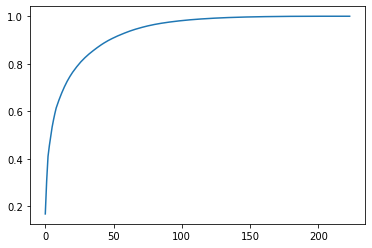

In [102]:
plt.plot(range(X_r.shape[1]), pca.explained_variance_ratio_.cumsum())

# PCA

In [113]:
scaler = StandardScaler()

X_pca = scaler.fit_transform(X_train_normalized)
X_test_pca = scaler.transform(X_test_normalized)
pca = PCA(125)

X_pca = pca.fit_transform(X_pca)
X_test_pca = pca.transform(X_test_pca)

In [114]:
train_test_forest(X_pca,X_test_pca,y_train,y_test)

              precision    recall  f1-score   support

           0       0.99      0.50      0.66     19316
           1       0.06      0.86      0.11       684

    accuracy                           0.51     20000
   macro avg       0.52      0.68      0.39     20000
weighted avg       0.96      0.51      0.64     20000



# LDA

In [118]:
lda = LinearDiscriminantAnalysis(n_components=1)

scaler = StandardScaler()

X_lda = scaler.fit_transform(X_train_normalized)
X_test_lda = scaler.transform(X_test_normalized)


X_lda = lda.fit_transform(X_lda,y_train)
X_test_lda = lda.transform(X_test_lda)

In [119]:
train_test_forest(X_pca,X_test_pca,y_train,y_test)

              precision    recall  f1-score   support

           0       0.99      0.23      0.38     19316
           1       0.04      0.91      0.08       684

    accuracy                           0.26     20000
   macro avg       0.51      0.57      0.23     20000
weighted avg       0.95      0.26      0.37     20000

